In [1]:
##Accidentally reset previous abundance analysis script using old scCoda. Reimplementation in pertpy to ensure no changes in outcome

import pertpy as pt

/well/immune-rep/users/vbw431/conda/skylake/envs/pertpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,8)
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc
import re
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [3]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"


In [4]:
adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat.h5ad")
##load data
labels = ["NK", "CD8", "CD4", "Bcells", "Myeloid_Plt"]
cluster_list = {}
scvi_list = {}
umap_list = {}
for i in [0,1,2,3,4]:
    print("reading in " + labels[i])
    cluster_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_clustering_final/", f"Peppa_{labels[i]}_cluster_assignment.csv"), index_col =0)
    scvi_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_embeddings/", f"Peppa_{labels[i]}_scvi.csv"), index_col =0)
    umap_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_embeddings/", f"Peppa_{labels[i]}_umap.csv"), index_col =0)

adata_list = {}

for i in [0,1,2,3, 4]:
    adata_list[labels[i]] = adata[cluster_list[labels[i]].index].copy()
    adata_list[labels[i]].obsm["X_scVI"] = scvi_list[labels[i]].loc[adata_list[labels[i]].obs_names].values
    adata_list[labels[i]].obsm["X_umap"] = umap_list[labels[i]].loc[adata_list[labels[i]].obs_names].values
    adata_list[labels[i]].obs = adata_list[labels[i]].obs.merge(cluster_list[labels[i]], left_index=True, right_index=True, how="inner")
    adata_list[labels[i]].layers['counts'] = adata_list[labels[i]].X.copy()
    sc.pp.normalize_total(adata_list[labels[i]], target_sum=1e4)
    sc.pp.log1p(adata_list[labels[i]])
    adata_list[labels[i]].layers['normalized'] = adata_list[labels[i]].X.copy()
    

reading in NK
reading in CD8
reading in CD4
reading in Bcells
reading in Myeloid_Plt


In [5]:
##update meta_data with new clinical
clin_meta = pd.read_csv(newdata_dir + "index_demo.csv", index_col = 0)
clin_meta = clin_meta[["disease_group", 
                       "bio_replicate", 
                       "study_disease", 
                       "scanpy_index", 
                       "study_ID", 
                       "Treatment_status",
                      "Ethnicity",
                      "Sex",
                      "Age",
                      "HBV_serostatus",
                      "HBV_sAg_titre",
                      "HBV_DNA_VL"]]


In [6]:
new_obs = {}

for name in labels:
    del adata_list[name].obs["disease_group"]
    del adata_list[name].obs["study_disease"]
    new_df = pd.merge(adata_list[name].obs, clin_meta, how='left', left_on = ['bio_replicate','scanpy_index'], right_on = ['bio_replicate','scanpy_index'])
    new_df.index = adata_list[name].obs.index
    new_obs[name] = new_df.copy()
    adata_list[name].obs = new_df.copy()

       

In [7]:
for name in labels:
    adata_list[name].obs["celltype_consensus.l1"] = str(name)
    adata_list[name].obs["celltype_consensus.l2"] = adata_list[name].obs[str(name+".annotation.l1")]
    
## subset for only on-treatment patients as pre-treatment samples only available in some
on_treatment = {}

for name in labels:
    on_treatment[name] = adata_list[name][adata_list[name].obs["Treatment_status"] != "Pre_treatment"].copy()

    
##concat
adata_all = anndata.concat(on_treatment, join= "outer", index_unique=None)

##Assign CMV status based on azimuth preprint (https://doi.org/10.1016/j.cell.2021.04.048)

conditions = [
  ([re.search("_0|SeuratProject",a) is not None for a in adata_all.obs["orig.ident"]]),
  ([re.search("_0|SeuratProject",a) is None for a in adata_all.obs["orig.ident"]]),
 ]

# create a list of the values we want to assign for each condition
values = ["Subset", "Remove"]

# create a new column and use np.select to assign values to it using our lists as arguments
adata_all.obs["prevax"] = np.select(conditions, values)

adata_all = adata_all[adata_all.obs["prevax"] == "Subset"].copy()

In [8]:
import importlib
importlib.reload(pt)
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(adata_all, type="cell_level", generate_sample_level=True, cell_type_identifier="celltype_consensus.l2", sample_identifier="bio_replicate", covariate_obs=["study_disease"])
print(sccoda_data)
print(sccoda_data["coda"].X)
print(sccoda_data["coda"].obs)

MuData object with n_obs × n_vars = 149239 × 23820
  2 modalities
    rna:	149222 x 23789
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'percent.ribo', 'percent.Ig', 'S.Score', 'G2M.Score', 'Phase', 'CITE_present', 'nCount_CITE', 'nFeature_CITE', 'nCount_protein_counts', 'nFeature_protein_counts', 'Hashtag.1', 'Hashtag.2', 'QC_label', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'solo_doublet_prob', 'solo_singlet_prob', 'solo_classification', 'nCount_CITE_seurat', 'nFeature_CITE_seurat', 'batch', 'scanpy_index', 'bio_replicate', 'CMV_status', 'Ref_lab', 'sample_id', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'nCount_SCT', 'nFeature_SCT', 'X_in

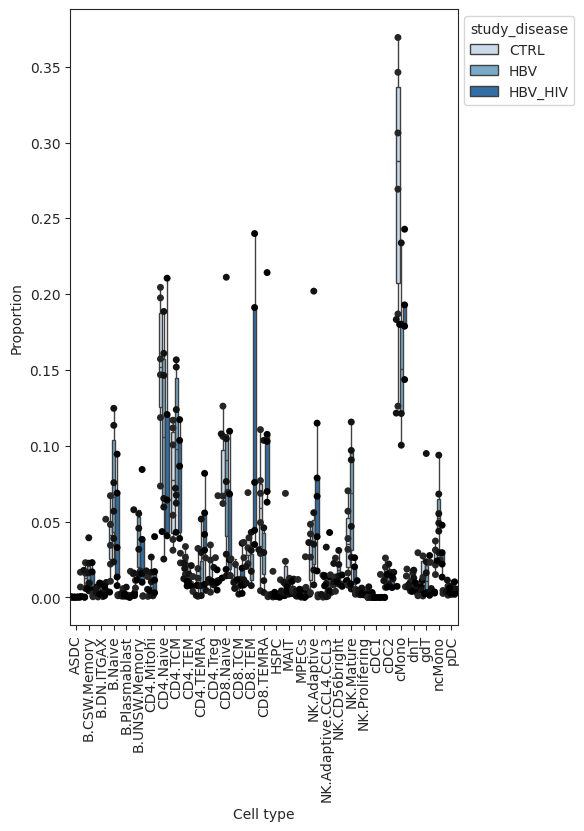

In [9]:
# plot boxplots
pt.pl.coda.boxplots(sccoda_data, modality_key="coda", feature_name="study_disease", add_dots=True)
plt.show()

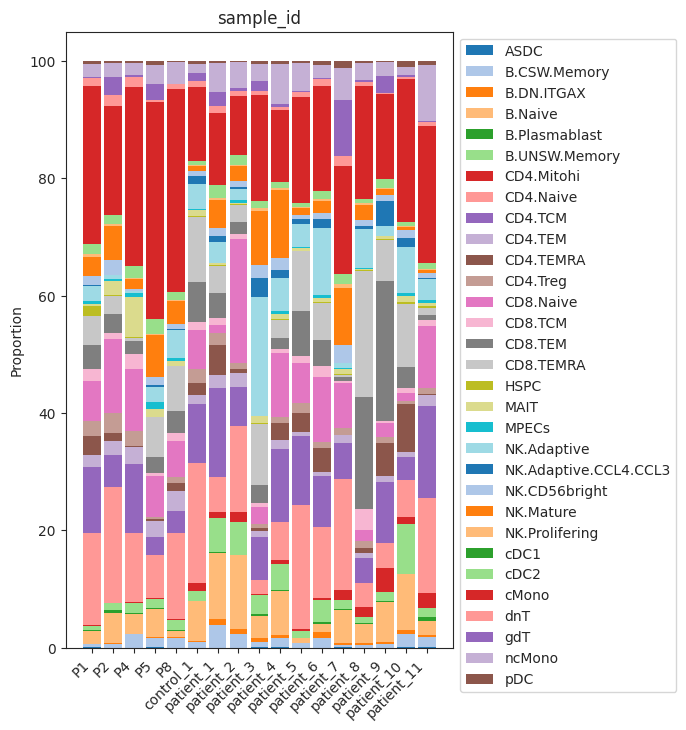

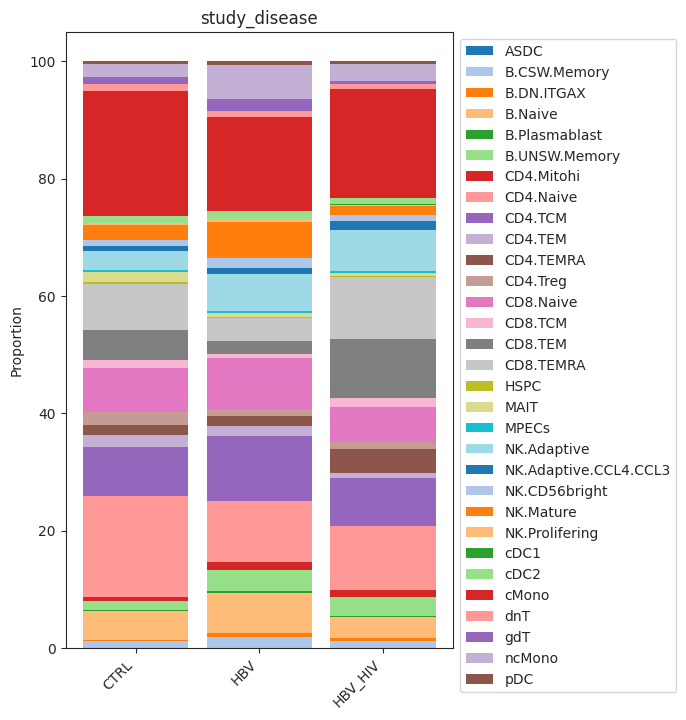

In [10]:
# Stacked barplot for each sample
pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="sample_id")
plt.show()

# Stacked barplot for the levels of "Condition"
pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="study_disease")
plt.show()

In [11]:
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda", formula="study_disease")
sccoda_data["coda"]

Automatic reference selection! Reference cell type set to NK.Prolifering

Zero counts encountered in data! Added a pseudocount of 0.5.

AnnData object with n_obs × n_vars = 17 × 31
    obs: 'orig.ident', 'batch', 'CMV_status', 'Ref_lab', 'sample_id', 'disease_group', 'study_disease', 'study_ID', 'Treatment_status', 'Ethnicity', 'Sex', 'HBV_serostatus', 'prevax'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

In [12]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
sample: 100%|█| 11000/11000 [09:23<00:00, 19.51it/s, 255 steps of size 2.14e-02.


AnnData object with n_obs × n_vars = 17 × 31
    obs: 'orig.ident', 'batch', 'CMV_status', 'Ref_lab', 'sample_id', 'disease_group', 'study_disease', 'study_ID', 'Treatment_status', 'Ethnicity', 'Sex', 'HBV_serostatus', 'prevax'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_study_disease[T.HBV]', 'effect_df_study_disease[T.HBV_HIV]'

In [13]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.4)
sccoda_model.summary(sccoda_data, modality_key="coda")


                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 17 samples, 31 cell types                                    │
│ Reference cell type                        │ NK.Prolifering                                                     │
│ Formula                                    │ study_disease                                                      │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ ASDC                       -1.434            28.722                                                             │
│ B.CSW.Memory                0.241           153.343                                                             │
│ B.DN.ITGAX                 -0.672            61.539                                                             │
│ B.Naive                     1.159           384.012                                                             │
│ B.Plasmablast              -0.863            50.840                                                             │
│ B.UNSW.Memory               0.612           222.222                                                             │
│ CD4.Mitohi                 -0.381            82.325                                                             │
│ CD4.Naive                   2.221          1110.621                                                             │
│ CD4.TCM                     1.770           707.456                                                             │
│ CD4.TEM                     0.504           199.472                                                             │
│ CD4.TEMRA                   0.087           131.456                                                             │
│ CD4.Treg                    0.315           165.120                                                             │
│ CD8.Naive                   1.666           637.577                                                             │
│ CD8.TCM                     0.170           142.833                                                             │
│ CD8.TEM                     1.001           327.889                                                             │
│ CD8.TEMRA                   1.128           372.291                                                             │
│ HSPC                       -0.898            49.091                                                             │
│ MAIT                        0.018           122.692                                                             │
│ MPECs                      -0.628            64.307                                                             │
│ NK.Adaptive                 0.815           272.237                                                             │
│ NK.Adaptive.CCL4.CCL3      -0.507            72.579                                                             │
│ NK.CD56bright               0.261           156.440                                                             │
│ NK.Mature                   0.927           304.501                                                             │
│ NK.Prolifering             -0.555            69.177                                                             │
│ cDC1                       -1.723            21.513                                                             │
│ cDC2                        0.307           163.805                                                             │
│ cMono                       2.846          2074.914                                                             │
│ dnT                         0.040           125.421                                                             │
│ gdT                        -0.117           107.198                                                             │
│ ncMono                      0.961           315.032   

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                               Final Parameter  Expected Sample  log2-fold change                │
│ Covariate              Cell Type                                                                                │
│ study_diseaseT.HBV     ASDC                        0.022            33.223            0.210                     │
│                        B.CSW.Memory                0.040           180.607            0.236                     │
│                        B.DN.ITGAX                  0.168            82.335            0.420                     │
│                        B.Naive                     0.256           561.333            0.548                     │
│                        B.Plasmablast               0.002            57.603            0.180                     │
│                        B.UNSW.Memory               0.208           309.366            0.477                     │
│                        CD4.Mitohi                  0.192           112.894            0.456                     │
│                        CD4.Naive                  -0.389           851.287           -0.384                     │
│                        CD4.TCM                     0.130           911.695            0.366                     │
│                        CD4.TEM                    -0.089           206.504            0.050                     │
│                        CD4.TEMRA                  -0.162           126.414           -0.056                     │
│                        CD4.Treg                   -0.107           167.807            0.023                     │
│                        CD8.Naive                  -0.141           626.294           -0.026                     │
│                        CD8.TCM                    -0.216           130.244           -0.133                     │
│                        CD8.TEM                    -0.398           249.081           -0.397                     │
│                        CD8.TEMRA                  -0.362           293.343           -0.344                     │
│                        HSPC                       -0.013            54.828            0.159                     │
│                        MAIT                       -0.168           117.327           -0.065                     │
│                        MPECs                      -0.112            65.058            0.017                     │
│                        NK.Adaptive                 0.145           356.114            0.387                     │
│                        NK.Adaptive.CCL4.CCL3       0.069            87.968            0.277                     │
│                        NK.CD56bright               0.071           190.047            0.281                     │
│                        NK.Mature                   0.195           418.627            0.459                     │
│                        NK.Prolifering              0.000            78.254            0.178                     │
│                        cDC1                       -0.013            24.026            0.159                     │
│                        cDC2                       -0.027           180.433            0.139                     │
│                        cMono                      -0.478          1455.371           -0.512                     │
│                        dnT                        -0.046           135.521            0.112                     │
│                        gdT                         0.157           141.856            0.404                     │
│                        ncMono                      0.2

In [14]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")


Covariate                 Cell Type    
study_disease[T.HBV]      ASDC              True
                          B.CSW.Memory      True
                          B.DN.ITGAX        True
                          B.Naive           True
                          B.Plasmablast     True
                                           ...  
study_disease[T.HBV_HIV]  cMono            False
                          dnT              False
                          gdT               True
                          ncMono           False
                          pDC              False
Name: Final Parameter, Length: 62, dtype: bool

In [15]:
credible_effects_HBV = sccoda_model.credible_effects(sccoda_data, modality_key="coda")["study_disease[T.HBV]"]
credible_effects_HBV_HIV = sccoda_model.credible_effects(sccoda_data, modality_key="coda")["study_disease[T.HBV_HIV]"]


In [16]:
#sccoda_data.write_h5mu(newdata_dir + "sccoda_peppa")


In [17]:

HBV_effect = sccoda_model.get_effect_df(sccoda_data, modality_key="coda").loc["study_diseaseT.HBV"]
HBV_HIV_effect = sccoda_model.get_effect_df(sccoda_data, modality_key="coda").loc["study_diseaseT.HBV_HIV"]

HBV_effect = HBV_effect.loc[credible_effects_HBV].reset_index()
HBV_HIV_effect = HBV_HIV_effect.loc[credible_effects_HBV_HIV].reset_index()

In [18]:
import rpy2.rinterface_lib.callbacks
import logging
#import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects import pandas2ri
#from rpy2.robjects import r
#from rpy2.ipython.ggplot import image_png

#sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
%load_ext rpy2.ipython

In [19]:
%%R

library(tidyverse)
library(RColorBrewer)

cur.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/out/"
references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"
com.out = "/well/immune-rep/users/vbw431/Projects/Peppa/reference_combat/"

##plotting
library(ggplot2); theme_set(theme_bw(base_size = 18)+
                              theme(strip.text = element_text(colour = 'black', face="bold",size=12), 
                                    panel.grid.major = element_blank(), 
                                    panel.grid.minor = element_blank(),
                                    panel.border = element_rect(size = 0.7),
                                    axis.ticks.length=unit(.10, "cm"),
                                    axis.ticks = element_line(size=0.7),
                                    strip.background = element_blank()))



-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


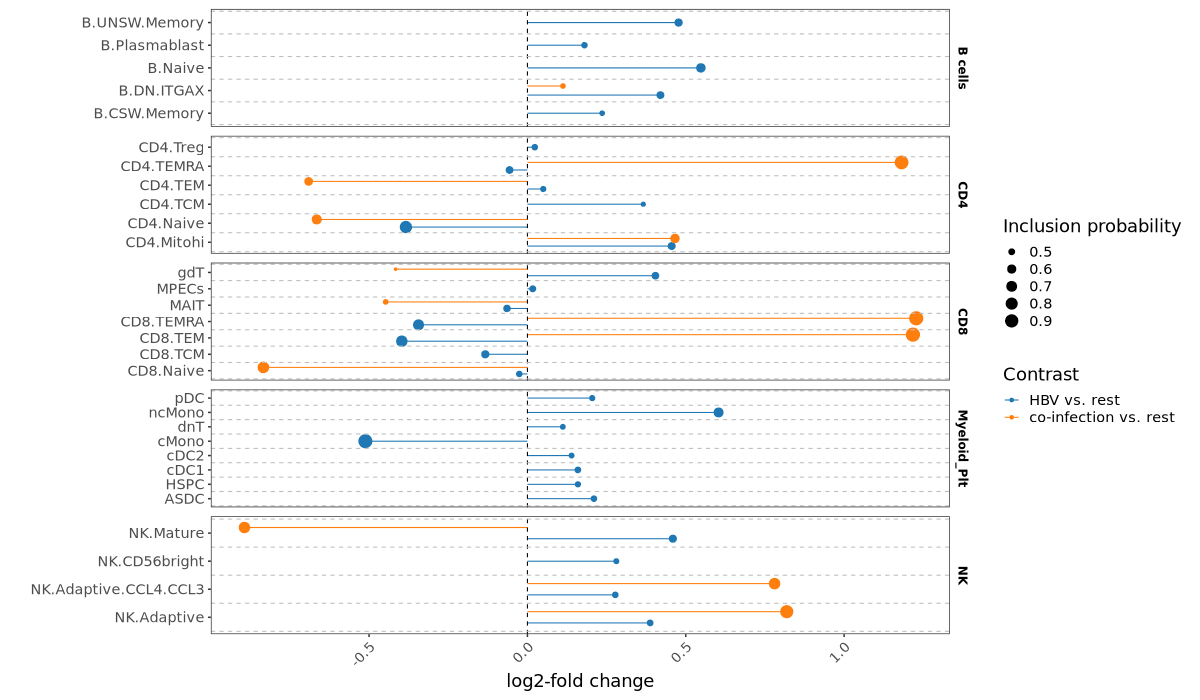

In [20]:
%%R -i HBV_effect -i HBV_HIV_effect -h 700 -w 1200
library(tidytext)

HBV_effect$contrast <- "HBV vs. rest"
HBV_HIV_effect$contrast <- "co-infection vs. rest"

combined <- rbind(HBV_effect, HBV_HIV_effect)

#combined %>% 
#ggplot(aes(reorder_within(`Cell Type`, `log2-fold change`, contrast), `log2-fold change`, fill = `log2-fold change`))+
#geom_col()+
#facet_wrap(~contrast, scales="free")+
#scale_x_reordered()+
#theme(axis.text.x = element_text(angle=45, hjust=1))+
# scale_fill_gradientn(colors = colorRampPalette(c("#276DAA", "white", "#DD1C28"))(100))+
#xlab("")

sccoda_prop <- combined %>% 
mutate(Contrast = contrast) %>%
mutate(`Parent Cell Type` = ifelse(grepl("^B.", `Cell Type`), "B cells",
                                  ifelse(grepl("^CD4.", `Cell Type`), "CD4",
                                        ifelse(grepl("^CD8.|MAIT|MPECs|gdT", `Cell Type`), "CD8",
                                              ifelse(grepl("^NK.", `Cell Type`), "NK", "Myeloid_Plt"))))) %>%
ggplot(aes(`Cell Type`, `log2-fold change`, color = Contrast))+
geom_point(aes(size=`Inclusion probability`), position = position_dodge(width = .8))+
geom_errorbar(aes(ymin=0, ymax = `log2-fold change`),
                   width = 0,
                   position = position_dodge(width = .8), size=0.5)+
geom_hline(yintercept = 0, linetype="dashed")+
geom_vline(lty = 2, xintercept=seq(from = 0.5, to = length(unique(combined$`Cell Type`)), by = 1),color="gray", size = 0.5)+

#facet_wrap(~contrast, scales="free")+
scale_x_reordered()+
theme(axis.text.x = element_text(angle=45, hjust=1))+
 #scale_fill_gradientn(colors = colorRampPalette(c("#276DAA", "white", "#DD1C28"))(100))+
ggsci::scale_color_d3()+
xlab("")+
facet_grid(vars(`Parent Cell Type`), scales="free_y")+
coord_flip()
print(sccoda_prop)

ggsave(sccoda_prop, file="/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/sccoda_prop.eps", device="eps",  width = 9, height = 11, units = "in")






In [21]:
HBV_HIV_effect

,Cell Type,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
0,B.DN.ITGAX,0.168324,-0.511,0.920,0.275,0.4697,66.513648,0.112144
1,CD4.Mitohi,0.413591,-0.296,1.156,0.368,0.6080,113.712579,0.465989
2,CD4.Naive,-0.370490,-0.817,0.030,0.261,0.6471,700.358834,-0.665201
3,CD4.TEM,-0.388209,-1.010,0.187,0.321,0.5728,123.578226,-0.690763
4,CD4.TEMRA,0.909543,0.182,1.574,0.406,0.9511,298.158785,1.181497
5,CD8.Naive,-0.487224,-0.945,0.003,0.311,0.7633,357.758676,-0.833612
6,CD8.TEM,0.934276,0.379,1.479,0.305,0.9918,762.314200,1.217179
7,CD8.TEMRA,0.941556,0.400,1.459,0.292,0.9925,871.868530,1.227681
8,MAIT,-0.219730,-0.908,0.412,0.268,0.4699,89.958919,-0.447700
9,NK.Adaptive,0.658133,-0.001,1.150,0.351,0.8902,480.206434,0.818789


In [22]:
HBV_effect

,Cell Type,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
0,ASDC,0.022271,-0.520,0.565,0.202,0.4936,33.222651,0.209995
1,B.CSW.Memory,0.040364,-0.430,0.504,0.169,0.4694,180.607103,0.236096
2,B.DN.ITGAX,0.167833,-0.319,0.741,0.224,0.5372,82.334742,0.419995
3,B.Naive,0.256354,-0.157,0.672,0.218,0.6169,561.332968,0.547704
4,B.Plasmablast,0.001614,-0.553,0.519,0.199,0.4899,57.602993,0.180192
5,B.UNSW.Memory,0.207565,-0.234,0.678,0.212,0.5534,309.365988,0.477316
6,CD4.Mitohi,0.192486,-0.313,0.767,0.238,0.5424,112.893685,0.455562
7,CD4.Naive,-0.389211,-0.796,0.010,0.251,0.8170,851.287395,-0.383649
8,CD4.TCM,0.130346,-0.183,0.491,0.141,0.4617,911.695458,0.365913
9,CD4.TEM,-0.088640,-0.570,0.387,0.184,0.4826,206.504181,0.049983


In [23]:
credible_effects_HBV

Cell Type
ASDC                      True
B.CSW.Memory              True
B.DN.ITGAX                True
B.Naive                   True
B.Plasmablast             True
B.UNSW.Memory             True
CD4.Mitohi                True
CD4.Naive                 True
CD4.TCM                   True
CD4.TEM                   True
CD4.TEMRA                 True
CD4.Treg                  True
CD8.Naive                 True
CD8.TCM                   True
CD8.TEM                   True
CD8.TEMRA                 True
HSPC                      True
MAIT                      True
MPECs                     True
NK.Adaptive               True
NK.Adaptive.CCL4.CCL3     True
NK.CD56bright             True
NK.Mature                 True
NK.Prolifering           False
cDC1                      True
cDC2                      True
cMono                     True
dnT                       True
gdT                       True
ncMono                    True
pDC                       True
Name: Final Parameter, dtype:

In [24]:
credible_effects_HBV_HIV

Cell Type
ASDC                     False
B.CSW.Memory             False
B.DN.ITGAX                True
B.Naive                  False
B.Plasmablast            False
B.UNSW.Memory            False
CD4.Mitohi                True
CD4.Naive                 True
CD4.TCM                  False
CD4.TEM                   True
CD4.TEMRA                 True
CD4.Treg                 False
CD8.Naive                 True
CD8.TCM                  False
CD8.TEM                   True
CD8.TEMRA                 True
HSPC                     False
MAIT                      True
MPECs                    False
NK.Adaptive               True
NK.Adaptive.CCL4.CCL3     True
NK.CD56bright            False
NK.Mature                 True
NK.Prolifering           False
cDC1                     False
cDC2                     False
cMono                    False
dnT                      False
gdT                       True
ncMono                   False
pDC                      False
Name: Final Parameter, dtype: